# __CNN Resnet para la clasificación de cultivos de palma de aceite en Colombia__

En el presente notebook se encuentra una CNN Resnet50 que tiene como objetivo la clasificación de cultivos de palma de aceite en Colombia.

### 1.Instalación de paquetes e importación de librerias necesarias

In [4]:
# Instalar TensorFlow si aún no lo tienes instalado
!pip install tensorflow==2.7.0
# Instalar MatPlotlib
!pip install matplotlib
#Intalar Numpy
!pip install numpy
# Instalación Scipy
!python -m pip install scipy
!pip install SciPy
#Instalar scikit-learn
!python -m pip install scikit-learn
# Instalar mlxtend
!pip install mlxtend
# Instalare Seaborn
!pip install seaborn

In [5]:
# Importar librerias necesarias
#TensorFlow 
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#Numpy
import numpy as np
# os
import os
#Keras 
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
# cv2
import cv2
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
#mlxtend
from mlxtend.plotting import plot_confusion_matrix
#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Lectura y organización de archivos en dos clases (PalmOil y NOTPalmOils), y en dos subconjuntos (Entrenamiento y Test)

In [5]:
# Cambiar cada una de las rutas donde se encuentran sus conjuntos de datos
images_path = "C:\\PalmOilDataSet\\final"
os.makedirs(os.path.join(images_path, "train", "NOTPalmOil"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "PalmOil"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "NOTPalmOil"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "PalmOil"), exist_ok=True)
os.makedirs(os.path.join(images_path, "validation", "NOTPalmOil"), exist_ok=True)
os.makedirs(os.path.join(images_path, "validation", "PalmOil"), exist_ok=True)

### 3. Preparación de los datos

A continuación se preparan los datos para el entrenamiento y la validación. En este caso , se utilizan dos generadores de imagenes: uno para el conjunto de datos de entrenamiento y otro para el conjunto de validación. Estos generadores se encargarán de leer las imágenes de los directorios correspondientesy aplicarles transformaciones.

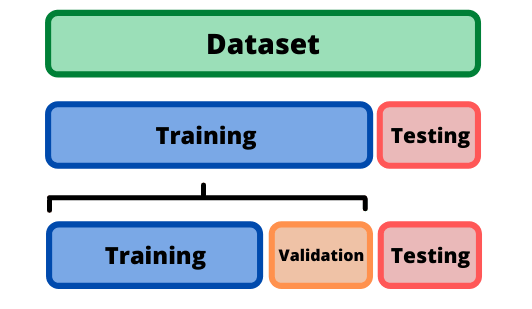


In [7]:
# Crear generadores de imágenes para entrenamiento y test
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(images_path, "train"),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(images_path, "validation"),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(images_path, "test"),
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 18884 images belonging to 2 classes.
Found 5398 images belonging to 2 classes.
Found 2699 images belonging to 2 classes.


### 4. CNN ResNet50

In [8]:
# Se carga el modelo pre-entrenado ResNet50
resnet = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(256, 256, 3)
)

In [9]:
# En este punto se procede a congelar las capas base para evitar que se modifiquen durante el entrenamiento
for layer in resnet.layers:
    layer.trainable = False

# Se agregan capas de clasificación al modelo con su correspondiente función de activación.
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [10]:
# Agregar capas de clasificación al modelo
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [11]:
# Creación del modelo
model = tf.keras.models.Model(inputs=resnet.input, outputs=preds)
#model = tf.keras.models.Model(inputs=pre_model.input, outputs=x)

Es necesario compilar el modelo antes de entrenarlo. En este caso, se utilizará el optimizador __Adam__, la función de perdida __categorical_crossentropy__ y la métrica __accuracy__.

In [12]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Antes de entrenar el modelo se procede a configurar una función de parada temprana (EarlyStopping) de Keras para detener el entrenamiento cuando el modelo ya no mejora. Esta función utiliza los siguientes parametros: 

__monitor__: La métrica que queremos monitorear, en este caso __val_accuracy__.

__min_delta__: La mejora mínima requerida para considerar que hay una mejora real. Un valor de 0 significa que cualquier mejora se considera significativa.

__patience__: Cuántas épocas esperar antes de detener el entrenamiento cuando la métrica no mejora.

__verbose__: Controla la cantidad de información que se muestra. Un valor de 1 indica que se mostrará información sobre la parada temprana.
__mode__: Indica si buscamos maximizar o minimizar la métrica. En este caso, queremos maximizar la precisión de validación, por lo que se usa '__max__'.

__baseline__: El valor de la métrica que queremos alcanzar antes de detener el entrenamiento. En este caso, 0.99 corresponde al 99% de precisión.

__restore_best_weights__: Si es __True__, restaura los pesos del modelo al mejor punto encontrado durante el entrenamiento.

In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=3, verbose=1, mode='max', baseline=None, restore_best_weights=False)

In [26]:
# Entrenamiento del modelo con los generadores preparados.
epochs=50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose = 1
    #validation_steps = np.ceil(len(val_generator)/15),
     #steps_per_epoch = np.ceil(len(train_generator)/15),
)

Epoch 1/50
591/591 [==============================] - 1089s 2s/step - loss: 0.2976 - accuracy: 0.8698 - val_loss: 0.3122 - val_accuracy: 0.8648
Epoch 2/50
591/591 [==============================] - 1100s 2s/step - loss: 0.2511 - accuracy: 0.8915 - val_loss: 0.2973 - val_accuracy: 0.8813
Epoch 3/50
591/591 [==============================] - 1099s 2s/step - loss: 0.2177 - accuracy: 0.9071 - val_loss: 0.3072 - val_accuracy: 0.8766
Epoch 4/50
591/591 [==============================] - 1113s 2s/step - loss: 0.1928 - accuracy: 0.9189 - val_loss: 0.3097 - val_accuracy: 0.8705
Epoch 5/50
591/591 [==============================] - 1107s 2s/step - loss: 0.1683 - accuracy: 0.9300 - val_loss: 0.2549 - val_accuracy: 0.8981
Epoch 6/50
591/591 [==============================] - 1100s 2s/step - loss: 0.1482 - accuracy: 0.9396 - val_loss: 0.2673 - val_accuracy: 0.8966
Epoch 7/50
591/591 [==============================] - 1103s 2s/step - loss: 0.1287 - accuracy: 0.9472 - val_loss: 0.2945 - val_accuracy:

In [27]:
#!mkdir -p saved_model
model.save("saved_model/4model_ResNet50_PalmOilDef.h5")

C:\Python37\opencv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [28]:
# Evaluar el rendimiento final del modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(test_generator)

print("Pérdida en los datos de prueba:", test_loss)
print("Precisión en los datos de prueba:", test_accuracy)

85/85 [==============================] - 4s 48ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Pérdida en los datos de prueba: 0.0
Precisión en los datos de prueba: 0.0


In [18]:
def plot_model(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

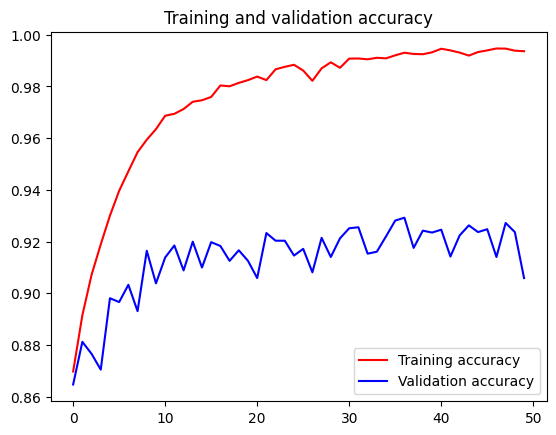

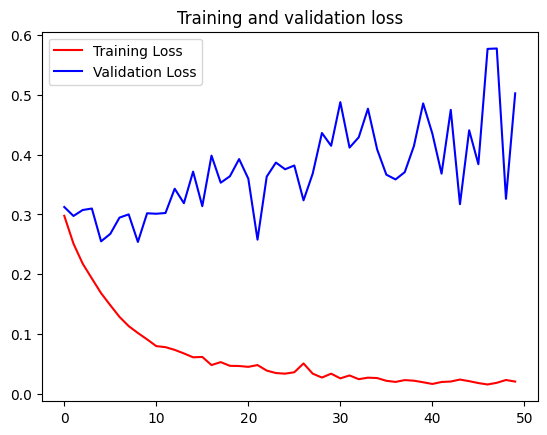

In [29]:
plot_model(history)

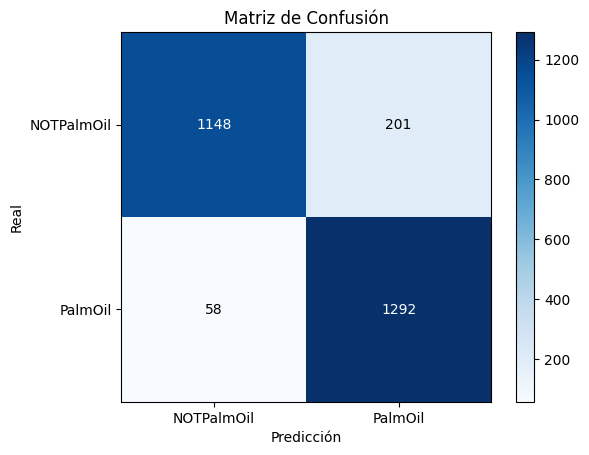

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo en los datos de prueba
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Crear matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Plot de la matriz de confusión
classes = list(test_generator.class_indices.keys())
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='Real',
       xlabel='Predicción')
# Añadir etiquetas centradas con información
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.title('Matriz de Confusión')
plt.show()

# Plot de test_loss y test_accuracy
#plt.plot(history.history['test_loss'], label='Pérdida en los datos de prueba')
#plt.plot(history.history['test_accuracy'], label='Precisión en los datos de prueba')
#plt.xlabel('Época')
#plt.ylabel('Valor')
#plt.title('Evolución de pérdida y precisión en los datos de prueba')
#plt.legend()
#plt.show()
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

Etiqueta predicha: PalmOil


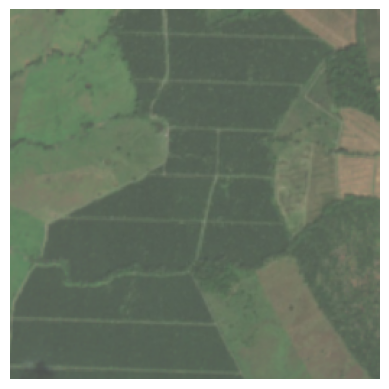

In [19]:


from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
import cv2

names = ['NOTPalmOil','PalmOil']

modelt = load_model("saved_model/4model_ResNet50_PalmOilDef.h5")

imaget_path = "C:/PalmOilDataSet/ExternalValidation256/Chigorodo_1_1300x1300.png"
imaget=cv2.resize(cv2.imread(imaget_path), (256, 256), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)


print("Etiqueta predicha:", names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [39]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
import cv2
import numpy as np
import os

def predecir_etiquetas(folder_path):
    names = ['NOTPalmOil', 'PalmOil']
    modelt = load_model("saved_model/4model_ResNet50_PalmOilDef.h5")
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            
            imaget = cv2.resize(cv2.imread(image_path), (256, 256), interpolation=cv2.INTER_AREA)
            xt = np.asarray(imaget)
            xt = preprocess_input(xt)
            xt = np.expand_dims(xt, axis=0)
            preds = modelt.predict(xt)
            
            print("Imagen", filename, "Etiqueta predicha:", names[np.argmax(preds)])
            #plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
            #plt.axis('off')
            #plt.show()


In [40]:
folder_path = "C:/PalmOilDataSet/ExternalValidation256"
predecir_etiquetas(folder_path)

Imagen Chigorodo_1_1300x1300.png Etiqueta predicha: PalmOil
Imagen Chigorodo_2_1200x1200.png Etiqueta predicha: PalmOil
Imagen Chigorodo_3_800x800.png Etiqueta predicha: PalmOil
Imagen Chigorodo_4_500x500.png Etiqueta predicha: PalmOil
Imagen Chigorodo_5_350x350.png Etiqueta predicha: PalmOil
Imagen Chigorodo_5_420x420.png Etiqueta predicha: PalmOil
Imagen Narino_10_1200.png Etiqueta predicha: PalmOil
Imagen Narino_1_1200.png Etiqueta predicha: PalmOil
Imagen Narino_1_800.png Etiqueta predicha: PalmOil
Imagen Narino_2_1200.png Etiqueta predicha: PalmOil
Imagen Narino_2_700.png Etiqueta predicha: PalmOil
Imagen Narino_2_800.png Etiqueta predicha: PalmOil
Imagen Narino_2_900.png Etiqueta predicha: PalmOil
Imagen Narino_31_630.png Etiqueta predicha: PalmOil
Imagen Narino_3_630.png Etiqueta predicha: NOTPalmOil
Imagen Narino_3_650.png Etiqueta predicha: PalmOil
Imagen Narino_4_400.png Etiqueta predicha: PalmOil
Imagen Narino_4_450.png Etiqueta predicha: PalmOil
Imagen Narino_4_500.png Etiq